# Tweet sentiment analysis

In [6]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cufflinks as cf
import plotly
import plotly.graph_objs as go
import datetime
import boto3
import s3fs
pd.set_option('display.max_colwidth', -1)
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Get dataframe from S3 bucket
Iterates over all objects in the tweet-object folder in the aws s3 bucket.
The objects are retrieved in JSON format and converted to a Pandas dataframe.

In [17]:
# # Read CSV file
# #tweets_today = pd.read_csv(r'..\datasets\raw_data\tweets{}.csv'.format(datetime.date.today()))
# tweets_today = pd.read_csv(r'..\datasets\raw_data\tweets2019-10-08.csv')
# tweets_today = tweets_today.head(5000)
# # Gets tweet texts
# tweets_today_text = tweets_today['tweet']
bucketname = 'ops-vw-interns-climate-perception-tweets'
dataframe = pd.DataFrame(columns=('creation date','keyword', 'tweet', 
                                  'username'))
s3 = boto3.resource('s3')

s3_tweets = s3.Bucket(bucketname).objects.filter(Prefix='objects/', Delimiter='/').all()
for file in s3_tweets:
    temp_df = pd.read_json('s3://{}/{}'.format(bucketname, file.key))
    dataframe = dataframe.append(temp_df, sort=False, ignore_index=True)
dataframe_tweets = dataframe['tweet']
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100177 entries, 0 to 100176
Data columns (total 4 columns):
creation date    100177 non-null object
keyword          21821 non-null object
tweet            100177 non-null object
username         100177 non-null object
dtypes: object(4)
memory usage: 3.1+ MB


## Data cleaning
Removing unneeded characters from the tweet texts like hashtags and urls

In [ ]:
keywords = ['climate change', 'climatechange', 'global warming', 'globalwarming']
pattern = '|'.join(keyword)
dataframe = dataframe[dataframe.apply(lambda row: row.tweet.lower().str.contains(pattern) , axis=1)]
dataframe.info()

In [18]:
# Preprocessing of tweet texts
def format_tweet(tweet):
    processed_tweet=''
    for word in tweet.split():
        # Removing URL from tweet
        processed_word = re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', word)
        
        # remove all single characters
        processed_word = re.sub('\s+[a-zA-Z]\s+', ' ', processed_word)
        
        # Remove single characters from the start
        processed_word = re.sub('\^[a-zA-Z]\s+', ' ', processed_word) 
        
        # Substituting multiple spaces with single space
        processed_word = re.sub('\s+', ' ', processed_word, flags=re.I)
        
        # Removing prefixed 'b'
        processed_word = re.sub('^b\s+', ' ', processed_word)
        
        # Removing &amp
        processed_word = re.sub('&amp', '&', processed_word)
        
        processed_word = re.sub('amp', '&', processed_word)
        
        # Removing breaks
        processed_word = re.sub('<br/>', '', processed_word)
        
        # converts to lower
        processed_word = processed_word.lower()
        processed_tweet= processed_tweet+' '+processed_word
    return processed_tweet        
    
tweets_text = [format_tweet(tweet) for tweet in dataframe_tweets]
print('unprocessed tweet: \n'+ dataframe['tweet'][15])
print('\nprocessed tweet: \n' + tweets_text[15])

unprocessed tweet: 
AOC: My ‘Dreams of Motherhood Now Bittersweet’ Because of Global Warming https://t.co/uUIM3uSbTi https://t.co/WFLq78IywX

processed tweet: 
 aoc  my  dreams of motherhood now bittersweet  because of global warming    


## Labeling tweets with NLTK vader
Provides te dataframe of the needed 'label' / 'target' column. In our case this column contains the sentiment values (Positive, Neutral, Negative)

In [19]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ViMs\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

The NLTK.vader library helps us label the tweets by giving the tweet text a positive, neutral and negative score. Based on those scores it calculates the 'compound' / 'total' score. This is the value that gets stored in the dataframe 

In [20]:
sid = SentimentIntensityAnalyzer()

for i, tweet in enumerate(tweets_text[50:55]):
    print('{0}:{1} \n{2}\n\n'.format(i+1, tweet, sid.polarity_scores(tweet)))

1: climate change evidence  how do we know   gt  vital signs of the planet  global climate change and global warming  how do we know it s happening  here s the evidence    
{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'compound': 0.5994}


2: the election  debate is over  stay on the track  lib s mistakes in four years must not be hidden   apologized  snc lavalin  climate change vs pipeline  international relations  economy down  huge deficit  list goes on  never repeated  libs must go  say no to libs   vote  no    
{'neg': 0.219, 'neu': 0.738, 'pos': 0.044, 'compound': -0.8054}


3: revealed  google made large contributions to climate change deniers   
{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.2732}


4: climate change  the devastating effect plastics have on our oceans  dwindling numbers of rare species  nah    
{'neg': 0.289, 'neu': 0.711, 'pos': 0.0, 'compound': -0.6908}


5:  pieces of junk   top level  japanese climate scientist rejects global warming panic   opinion   

In [21]:
# Creates the text labels for the dataframe
def get_sentiment(polarity):
    if polarity < 0:
        return 'negative'
    if polarity > 0:
        return 'positive'
    else:
        return 'neutral'

word_count = [len(tweet.split()) for tweet in tweets_text]

polarity_tweets = [round(sid.polarity_scores(tweet)['compound'], 2)
                   for tweet in tweets_text]

sentiment_tweets = [get_sentiment(polarity) for polarity in polarity_tweets]

zipped_list = list(zip(sentiment_tweets, polarity_tweets,
                       tweets_text, word_count, dataframe['keyword'],
                       dataframe['username'], dataframe['creation date']))


# Store to new dataframe with sentiment values and polarities
sentiment_df = pd.DataFrame(zipped_list, 
                            columns=['Sentiment', 'Polarity', 
                                     'Tweet', 'Word count', 'Keyword', 'Username', 
                                     'Creation Date'])
sentiment_df.sample(15)

Sentiment  Polarity  \
84411  negative -0.36       
79607  positive  0.30       
78179  negative -0.87       
52890  positive  0.51       
4099   positive  0.82       
97209  neutral   0.00       
34436  negative -0.65       
79774  negative -0.20       
83965  negative -0.11       
2943   negative -0.59       
64066  negative -0.60       
86240  negative -0.23       
98075  neutral   0.00       
71699  positive  0.23       
74386  negative -0.54       

                                                                                                                                                                                                                                                                           Tweet  \
84411   el paso shooter wanted to kill people to save environment   a climate change whacko  &  a democrat frontpagemag                                                                                                                                                            
79607    proud to have marched alongside  gretathunberg and thousands of youth demanding action on climate change   climatestrike  climatestrikela  thisiswhaydemocracylookslike                                                                                                   
78179   illegal aliens cause global warming they are an existential threat to our environment  a wall is the only way to solve this climate change crisis                                                                                                                          
52890   can regenerative agriculture reverse  climatechange  big food thinks so  and some companies are investing in environmentally friendly practices that build soil organic matter and draw more carbon out of the atmosphere                                                  
4099    front row for an excellent  aberdeenuni talk from the brilliant adam price as part of the  aurora org  sdgs lecture series  the impact of climate change on rice  and vice versa  catch it here                                                                            
97209   you get what you get                                                                                                                                                                                                                                                       
34436   jane fonda arrested again at climate change protest   good place  star ted danson also arrested                                                                                                                                                                            
79774   87 percent of americans unaware there s scientific consensus on climate change   the weather channel                                                                                                                                                                       
83965    new science by a global team of ipcc researchers based at oxford university  shows categorically that methane from britain s ruminants is not causing global warming                                                                                                      
2943    any man can shoot a gun i m tryna change the climate                                                                                                                                                                                                                       
64066     al gore is opening a new front in the war on climate change    via  googlenews                                                                                                                                                                                           
86240   why should the whole world suffer for the convenience of the super rich  kanye west and dj khalid recently flew their private jets to exchange shoes  people are dying due to climate change  ban all private jets  they re n

In [22]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100177 entries, 0 to 100176
Data columns (total 7 columns):
Sentiment        100177 non-null object
Polarity         100177 non-null float64
Tweet            100177 non-null object
Word count       100177 non-null int64
Keyword          21821 non-null object
Username         100177 non-null object
Creation Date    100177 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 5.4+ MB


In [23]:
print('5 most negative tweets: \n')
top5_negative = pd.DataFrame(sentiment_df.sort_values('Polarity')[['Tweet','Polarity']].head(5))
top5_negative

5 most negative tweets: 



Tweet  \
57991   can t die from climate change if you already died from net neutrality if you already died from vaping if you already died from gun culture if you already died from immigration if you already died from terrorism if you already died from trump if you already died from patriarchy if   
22660   capitalism is murder  cyberbullying is murder  minimum wage is murder  billionaires existing is murder  homicide is murder  global warming is murder  a group of crows is murder  angela lansbury is murder  she wrote                                                                     
88721   leftists are always fake  fake news  fake science   global warming cooling change  fake scholarship  fake outrage  fake military heros  fake minorities  fake whistleblowers  fake witnesses  fake accusations  fake town hall questioners  why do people believe any of it                
72132   the young hate the old hate the young  the tories hate the labour hate the snp hate the greens  the climate change deniers hate the climate change obsessives  the rich hate the poor  westminster hates everybody  i hate how the fucking world is now                                    
87564   one racist moron  asking another racist moron who s to blame  what other answer would you expect   it s always the evil white man that s to blame  global warming  wars  poor tire wear  all our fault                                                                                     

       Polarity  
57991 -0.99      
22660 -0.99      
88721 -0.99      
72132 -0.99      
87564 -0.99

In [24]:
print('5 most positive tweets: \n')
top5_positive = sentiment_df.sort_values('Polarity', ascending=False)[['Tweet', 'Polarity']].head(5)
top5_positive

5 most positive tweets: 



Tweet  \
98943   what if global warming was all a hoax and 300 years from now some annoying kid comes up to your great great great great grandchild and says  hah  my great great great great grandpa told ya so                                                                   
39530   happy diwali to all  have fun  have great food  enjoy  also don t forget that climate change is a real concern  be safe  and try your best to keep it environment friendly  keep the animals safe  it s a festival for everyone  let s not steal their freedom    
66328   proudly presenting   invention  &  innovation incubator  let s change live and the world for the better  isn t it about time   climate  climatechange  bullying  honour  respect  love loyalty  laughter  liberty  life                                           
56662   in all honesty  i think it s time we step up to address climate change by bringing back heelys  no fossil fuels  no electricity  gets you places faster  lots of fun  and they impress everyone around you  that s called a win win win win win                   
41177   success takes many shapes and forms  it can be a successful career  your efforts to fight global warming  writing a great book  helping the homeless  etc   thrive  success  inspiration  talent  motivation                                                      

       Polarity  
98943  0.99      
39530  0.98      
66328  0.98      
56662  0.98      
41177  0.98

## Data visualisation

In [25]:
colors = ['red', 'yellow', 'green']
sentiment_df['Sentiment'].iplot(
    kind='hist',
    linecolor='black',
    theme='ggplot',
    colors = colors,
    xTitle='Sentiment',
    yTitle='count',
    title='Class distribution')

In [26]:
sentiment_df['Polarity'].iplot(
    kind='hist',
    bins=75,
    linecolor='black',
    theme='ggplot',
    xTitle='polarity',
    yTitle='count',
    title='Sentiment Polarity Distribution')
plt.show()

In [27]:
sentiment_df['Word count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    colors='blue',
    theme="ggplot",
    yTitle='count',
    title='Tweet text word count distribution')

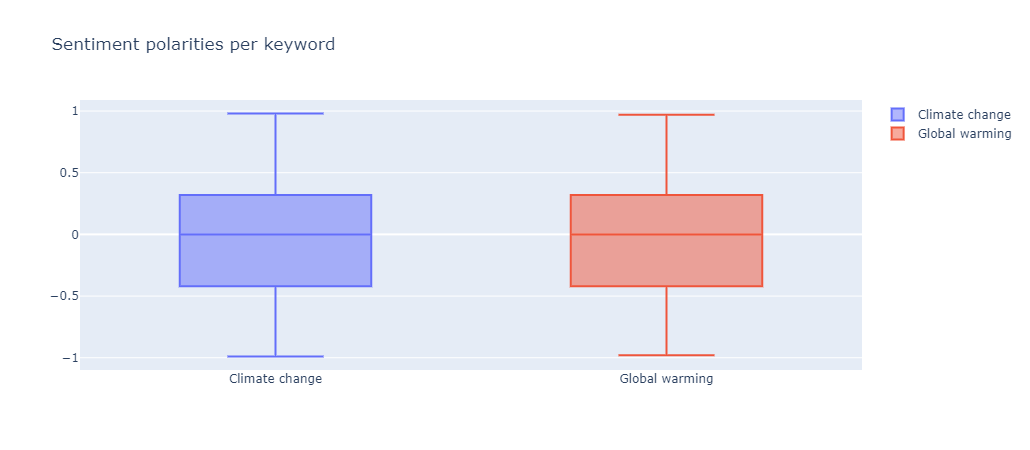

In [74]:
CC_polarities = sentiment_df[sentiment_df['Keyword']=='Climate change']['Polarity']
GW_polarities = sentiment_df[sentiment_df['Keyword']=='Global warming']['Polarity']

boxplot = go.Figure()
boxplot.add_trace(go.Box(y=CC_polarities, name = 'Climate change'))
boxplot.add_trace(go.Box(y=GW_polarities, name = 'Global warming'))

boxplot.update_layout(title_text='Sentiment polarities per keyword')
boxplot.show()

## Implementing machine learning classifiers

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.target import ClassBalance
from yellowbrick.features.pca import PCADecomposition

### Divide into training and test sets
We create our feature and label sets for training and testing using sklearn's train_test_split. 80% of the data will go to training sets and 20% will go to the testing sets. The method shuffles the data in a random order to make sure the sets are not unbalanced.

In [29]:
from sklearn.model_selection import train_test_split

# Extract features from df
features = sentiment_df['Tweet']

# Extract labels from df
labels = sentiment_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels, test_size=0.2,
                                                    random_state=1)

print('Training set contains: '+str(len(X_train))+ ' samples')
print('Testing set contains: '+str(len(X_test))+ ' samples')

Training set contains: 80141 samples
Testing set contains: 20036 samples


### Preparing pipeline variables
Setup of tokenizers (converting 1 text object to a list of text objects)
and vectorizers

In [30]:
count_vec = CountVectorizer(strip_accents=None, lowercase=False, 
                            preprocessor = None)
tfidf = TfidfTransformer()

def tokenizer(text):
    return text.split()

porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

#### Testing tokenizers

In [31]:
sample_tweet = 'Hi i think global warming is awesome. What about you?'

token_list = tokenizer(sample_tweet)

porter_list =tokenizer_porter(sample_tweet)

In [32]:
count_vec.fit(token_list)
print('With normal tokenizer:')
count_vec.vocabulary_

With normal tokenizer:


{'Hi': 0,
 'think': 6,
 'global': 4,
 'warming': 7,
 'is': 5,
 'awesome': 3,
 'What': 1,
 'about': 2,
 'you': 8}

In [33]:
count_vec.fit(porter_list)
print('With porter tokenizer (stemmer):')
count_vec.vocabulary_

With porter tokenizer (stemmer):


{'Hi': 0,
 'think': 5,
 'global': 3,
 'warm': 6,
 'is': 4,
 'awesome': 2,
 'what': 7,
 'about': 1,
 'you': 8}

In [35]:
from sklearn.linear_model import LogisticRegression

In [36]:
import warnings
warnings.filterwarnings('ignore')

lr_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', LogisticRegression(random_state=1))])

param_grid_lr ={
                'vect__ngram_range': [(1,1),(1,2)],
                'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],
    
                'clf__dual': [True, False],
                'clf__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2 ],
                'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'clf__fit_intercept': [True, False],
                'clf__max_iter' : [100, 110, 120, 130, 140],
                'clf__warm_start': [True, False]
              }
grid_lr = RandomizedSearchCV(lr_pipeline, param_grid_lr, n_iter=10,
                             verbose=10, cv=5, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train, y_train)
print()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 15.8min finished


In [58]:
print('Best parameters: ', grid_lr.best_params_)

print('\nThe Logistic Regression classifier has reached an accuracy of: {:.2f}% \n'
      .format(grid_lr.best_score_*100))

Best parameters:  {'vect__tokenizer': <function tokenizer at 0x0000024844DF3510>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l1', 'clf__warm_start': False, 'clf__tol': 0.0001, 'clf__max_iter': 100, 'clf__fit_intercept': True, 'clf__dual': True, 'clf__C': 100}

The Logistic Regression classifier has reached an accuracy of: 88.80% 



### Implementing Multinomial Naive Bayes
Based on Bayes theorem. Predicts the probability of an output based on combination of given input parameters

In [25]:
from sklearn.naive_bayes import MultinomialNB

In [34]:
mnb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                         ('clf', MultinomialNB())])

param_grid_mnb = {
                  'vect__ngram_range': [(1,1), (1,2), (1,3)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],
    
                  'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'clf__fit_prior': [True, False]
                 }
grid_mnb = RandomizedSearchCV(mnb_pipeline, param_grid_mnb, n_iter=50,
                              cv=5, verbose=10, n_jobs=-1, scoring='accuracy')
grid_mnb.fit(X_train, y_train)
print()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  1.8min remaining:   20.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


In [35]:
print('Best parameters: ',grid_mnb.best_params_)

print('\nThe Multinomial Naive Bayes classifier has reached an accuracy of: {:.2f}% \n'
      .format(grid_mnb.best_score_*100))

Best parameters:  {'vect__tokenizer': <function tokenizer at 0x0000022F82B276A8>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__fit_prior': False, 'clf__alpha': 0.01}

The Multinomial Naive Bayes classifier has reached an accuracy of: 74.66% 



### Implementing Support Vector Machine

In [26]:
from sklearn.svm import SVC

In [ ]:
svc_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', SVC(random_state=1))])

param_grid_svm = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__C': [0.1, 1, 10, 100],
                  'clf__kernel': ['linear', 'rbf', 'poly'],
                  'clf__gamma': [0.1, 1, 10, 100],
                  'clf__degree': [0, 1, 2, 3, 4, 5, 6]
                 }

grid_svc = RandomizedSearchCV(svc_pipeline, param_grid_svm, n_iter=50, 
                              cv=5, verbose=10, n_jobs=-1, scoring='accuracy')
grid_svc.fit(X_train, y_train)
print()

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 256.2min


In [ ]:
print('Best parameters: ', grid_svc.best_params_)

print('\nThe Support Vector classifier has reached an accuracy of: {:.2f}% \n'
      .format(grid_svm.best_score_(X_test, y_test)*100))

### Implementing decision tree
Tries to determin the class/label of a datapoint based on sequential conditions

In [21]:
from sklearn import tree

In [22]:
dt_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', tree.DecisionTreeClassifier(random_state=1))])

param_grid_dt = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__max_depth': np.arange(1, 100),
                  'clf__max_features': np.arange(1, 50),
                  'clf__min_samples_leaf': np.arange(1, 50),
                  'clf__criterion':['gini','entropy']
                 }

grid_dt = RandomizedSearchCV(dt_pipeline, param_grid_dt, n_iter=50, 
                              cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
grid_dt.fit(X_train, y_train)
print()

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 27.5min finished


In [32]:
print(grid_dt.best_params_)

print('\nThe decision tree classifier has reached an accuracy of: {:.2f}% \n'
      .format(grid_dt.best_score_*100))

{'vect__tokenizer': <function tokenizer_porter at 0x0000022F82B27840>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__min_samples_leaf': 2, 'clf__max_features': 28, 'clf__max_depth': 62, 'clf__criterion': 'entropy'}

The decision tree classifier has reached an accuracy of: 46.29% 



### Implementing Random Forest
Combination of many random decision trees

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', RandomForestClassifier(random_state=1))])

param_grid_rf = {
                 'vect__ngram_range': [(1,1),(1,2), (1,3)],
                 'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],                  
    
                 'clf__n_estimators': [500, 750, 1000, 1500],
                 'clf__max_features': ['auto', 'sqrt'],
                 'clf__max_depth': np.linspace(1, 64, 32, endpoint=True),
                 'clf__min_samples_split': [2, 5, 10],
                 'clf__min_samples_leaf': [1, 2, 4],
                 'clf__bootstrap': [True, False]
                }

grid_rf = RandomizedSearchCV(rf_pipeline, param_grid_rf,
                             cv=5, n_iter=40 , verbose=10, n_jobs=-1, 
                             scoring='accuracy')

grid_rf.fit(X_train, y_train)
print()

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.8min


In [ ]:
print(grid_rf.best_params_)

print('\nThe Random Forest classifier has reached an accuracy of: {:.2f}% \n'
      .format(grid_rf.best_score_*100))

### Testing XGBoost (extreme gradient boosting)

In [42]:
import xgboost
from graphviz import Digraph
from xgboost import plot_tree

In [39]:
xgb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', xgboost.XGBClassifier())])

param_grid_xgb = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__learning_rate'    : [0.005, 0.01, 0.05, 0.10, 0.15, 0.20] ,
                  # Defines how many different features are used in each tree
                  'clf__max_depth'        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                  'clf__min_child_weight' : [ 1, 3, 5, 7 ],
                  'clf__gamma'            : [ 0, 0.01, 1, 5 ],
                  'clf__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
                  'clf__n_estimators'     : [ 10, 100, 1000]
                 }

grid_xgb = RandomizedSearchCV(xgb_pipeline, param_grid_xgb, n_iter=4, 
                              cv=2, verbose=5, n_jobs=-1, scoring='accuracy')
grid_xgb.fit(X_train, y_train)
print()

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed: 24.9min remaining: 41.4min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed: 26.6min remaining: 16.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 75.7min finished


In [62]:
print('Best parameters chosen by grid search: \n'+str(grid_xgb.best_params_))
#Create classifier based on best parameters
print('\nThe XGBoost  classifier has reached an accuracy of: {:.2f}% \n'
       .format(grid_xgb.best_score_*100))

xgb_results = pd.DataFrame.from_dict(grid_xgb.cv_results_)

pd.set_option('display.max_colwidth', 50)

grid_xgb.cv_results_

Best parameters chosen by grid search: 
{'vect__tokenizer': <function tokenizer at 0x0000024844DF3510>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__n_estimators': 1000, 'clf__min_child_weight': 3, 'clf__max_depth': 6, 'clf__learning_rate': 0.2, 'clf__gamma': 1, 'clf__colsample_bytree': 0.4}

The XGBoost  classifier has reached an accuracy of: 87.51% 



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0    1038.802137      0.407469        29.164701        0.045384   
1    4474.244307     14.405867        51.098973        2.201769   
2     414.151385      0.376462         5.920262        0.025792   
3      99.815379      0.041413         4.989012        0.041913   

                               param_vect__tokenizer param_vect__ngram_range  \
0         <function tokenizer at 0x0000024844DF3510>                  (1, 1)   
1  <function tokenizer_porter at 0x0000024838E7B730>                  (1, 2)   
2         <function tokenizer at 0x0000024844DF3510>                  (1, 2)   
3         <function tokenizer at 0x0000024844DF3510>                  (1, 2)   

  param_tfidf__use_idf param_tfidf__norm param_clf__n_estimators  \
0                False                l2                    1000   
1                False                l2                    1000   
2                 True                l2                     100   
3                False                l2                      10   

  param_clf__min_child_weight param_clf__max_depth param_clf__learning_rate  \
0                           3                    6                      0.2   
1                           5                    8                      0.2   
2                           1                    4                     0.15   
3                           3                    6                     0.15   

  param_clf__gamma param_clf__colsample_bytree  \
0                1                         0.4   
1             0.01                         0.4   
2                1                         0.4   
3                0                         0.7   

                                              params  split0_test_score  \
0  {'vect__tokenizer': <function tokenizer at 0x0...           0.875225   
1  {'vect__tokenizer': <function tokenizer_porter...           0.874850   
2  {'vect__tokenizer': <function tokenizer at 0x0...           0.709423   
3  {'vect__tokenizer': <function tokenizer at 0x0...           0.599820   

   split1_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.874941         0.875083        0.000142                1  
1           0.873269         0.874059        0.000791                2  
2           0.710974         0.710198        0.000775                3  
3           0.586938         0.593379        0.006441                4

In [45]:
plot_tree(xgb._Booster)
plt.show()

AttributeError: 'Pipeline' object has no attribute '_Booster'

## Comparing clasiffier results

### Confusion matrices
Matrix that shows the true and false predictions per class

In [ ]:
classes = ['positive', 'neutral', 'negative']
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ConfusionMatrix(model=mnb, classes=classes, ax=ax[0,0]),
    ConfusionMatrix(model=lr, classes=classes, ax=ax[0,1]),
    ConfusionMatrix(model=svm, classes=classes, ax=ax[1,0]),
    ConfusionMatrix(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()


### ROCAUC curve
tradeoff between the model’s sensitivity and specificity

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15), tight_layout=True)

visualgrid = [
    ROCAUC(model=mnb, classes=classes, ax=ax[0,0], micro=False, macro=False),
    ROCAUC(model=lr, classes=classes, ax=ax[0,1], micro=False, macro=False),
    ROCAUC(model=svm, classes=classes, ax=ax[1,0], micro=False, macro=False),
    ROCAUC(model=rf, classes=classes, ax=ax[1,1], micro=False, macro=False)
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()


### Classification reports
Report on the accuracy of the classifier

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ClassificationReport(model=mnb, classes=classes, ax=ax[0,0]),
    ClassificationReport(model=lr, classes=classes, ax=ax[0,1]),
    ClassificationReport(model=svm, classes=classes, ax=ax[1,0]),
    ClassificationReport(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()
